In [1]:
import numpy as np
import pandas as pd
import math

########
# PINTAR DATOS
########

In [2]:
# Importo los datos de la muestra que me facilitan para la prueba
data = pd.read_fwf('Meteologica_vacante_ProgPredR_ProblemaDatos_20190910.txt', parse_dates=['observaciones'])

In [3]:
# Como una de las filas tiene la string 'predicciones' y Nan, hago split para después sacar arrays
split = data.loc[data['observaciones'] == 'predicciones'].index.values.astype(int)[0]
df_observation = data[:split]
df_prediction = data[split+1:]

In [4]:
# Renombro las columnas para luego usar los nombres que quiero
df_observation[['production','wind_mod']] = df_observation['Unnamed: 1'].str.split(" ",expand=True)
df_observation = df_observation[[x for x in df_observation.columns if x != 'Unnamed: 1']]
df_predict = df_prediction.rename(columns={'Unnamed: 1': 'wind_mod'})

/home/slimbook/miniconda3/envs/ironhack_env/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [40]:
# Defino los errores para poder usarlos más adelante

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))

def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

In [6]:
# Me indican que las variables son:
### Valor k = range(1/2 - 3/2)
### Valor L = max(wind_mod)
### Valor x0 = range(0 - max(wind_mod))

In [7]:
# Defino las listas que usaré después y las variables
wind_mod = list(map(int, list(df_observation['wind_mod'])))
production = list(map(int, list(df_observation['production'])))
wind_mod_pred = list(map(int, list(df_predict['wind_mod'])))

L = float(max(wind_mod))
k = (np.arange(0.5,1.5,0.05)).tolist()
x0 = (np.linspace(start=0, stop=L, num=20)).tolist()

In [8]:
#### FUNCION #### TRAIN ####

result = []
parameters = []
mse_err = []
rmse_err = []
for x in wind_mod:
    for i in k:
        for s in x0:
            
            try:
                func = L/(1-math.exp(-(i)*((x)-(s))))
                params = [i, s]
                
                if func > 0: # He puesto esta condición porque previamente me salían valores negativos
                    result.append(func)
                    parameters.append(params)
                    
                    # Defino dos arrays para cálculo de errores
                    actual_array = np.asarray(func, dtype=np.float32)
                    predicted_array = np.asarray(wind_mod_pred, dtype=np.float32)

                    mse_err.append(mse(actual_array, predicted_array))
                    rmse_err.append(rmse(actual_array, predicted_array))
                
            except ZeroDivisionError:
                continue

In [9]:
# Imprimo algunos ejemplos para conocer resultados

print('Tipo de elemento que devuelve la función de error: ',type(rmse_err[0]))
print('Valor de RMSE mínimo: ',np.amin(rmse_err))
print('Índice para el RMSE mín: ',np.argmin(rmse_err))
print('Valor de MSE mínimo: ',np.amin(mse_err))
print('Índice para el MSE mín: ',np.argmin(mse_err))

print('Parámetros optimizados para el RMSE: ',parameters[(int(np.argmin(rmse_err)))])
print('Parámetros optimizados para el MSE: ',parameters[(int(np.argmin(mse_err)))])

print('Valor de la función para el RMSE min: ',result[(int(np.argmin(rmse_err)))])
print('Valor de la función para el MSE min: ',result[(int(np.argmin(mse_err)))])

print('Valor del wind_mod para el valor min de RMSE: ',wind_mod[(int(np.argmin(rmse_err)))])
print('Valor del wind_mod para el valor min de RMSE: ',wind_mod[(int(np.argmin(mse_err)))])

Tipo de elemento que devuelve la función de error:  <class 'numpy.float32'>
Valor de RMSE mínimo:  97.65098
Índice para el RMSE mín:  0
Valor de MSE mínimo:  9535.714
Índice para el MSE mín:  0
Parámetros optimizados para el RMSE:  [0.5, 0.0]
Parámetros optimizados para el MSE:  [0.5, 0.0]
Valor de la función para el RMSE min:  136.00000207127727
Valor de la función para el MSE min:  136.00000207127727
Valor del wind_mod para el valor min de RMSE:  36
Valor del wind_mod para el valor min de RMSE:  36


In [10]:
rmse_best_k = parameters[(int(np.argmin(rmse_err)))][0]
rmse_best_x0 = parameters[(int(np.argmin(rmse_err)))][1]

mse_best_k = parameters[(int(np.argmin(mse_err)))][0]
mse_best_x0 = parameters[(int(np.argmin(mse_err)))][1]

rmse_output = (int(np.amin(rmse_err)))/100
mse_output = (int(np.amin(mse_err)))/100


In [11]:
#### FUNCION #### FIT ####

wind_mod_pred_rmse = []
wind_mod_pred_mse = []


for x in wind_mod_pred:
    funcion_params_rmse = L/(1-math.exp(-(rmse_best_k)*((x)-rmse_best_x0)))
    funcion_params_mse = L/(1-math.exp(-(mse_best_k)*((x)-mse_best_x0)))
    
    wind_mod_pred_rmse.append(funcion_params_rmse)
    wind_mod_pred_mse.append(funcion_params_mse)


In [12]:
display(wind_mod_pred_rmse)
display(wind_mod_pred_mse) 

[136.0000000000047,
 136.00000000000105,
 136.00000000000003,
 136.00000046216442,
 136.0003074054942,
 136.0061746707773,
 157.28639941395454]

[136.0000000000047,
 136.00000000000105,
 136.00000000000003,
 136.00000046216442,
 136.0003074054942,
 136.0061746707773,
 157.28639941395454]

In [13]:
df_predict["production"] = [ '%.2f' % elem for elem in wind_mod_pred_rmse ]

In [14]:
# OUTPUT

print(L , rmse_best_k, rmse_best_x0)
print(mse_output, rmse_output)
print(df_predict[["observaciones","production"]])

136.0 0.5 0.0
95.35 0.97
         observaciones production
2875  2009-11-12 00:00     136.00
2876  2009-11-15 03:00     136.00
2877  2009-11-12 06:00     136.00
2878  2009-11-12 09:00     136.00
2879  2009-11-16 12:00     136.00
2880  2009-11-28 18:00     136.01
2881  2009-11-13 00:00     157.29


In [49]:
df_predict['production'] = pd.to_numeric(df_predict['production'])
print(df_predict['production'])

2875    -41.53
2876    463.44
2877    136.44
2878     -0.00
2879     -0.00
2880     -0.00
2881     -0.00
Name: production, dtype: float64


TypeError: can't multiply sequence by non-int of type 'float'

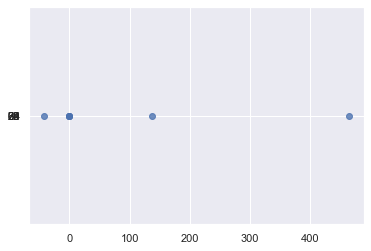

In [50]:
import seaborn as sns; sns.set()

ax = sns.regplot(x="production", y="wind_mod", data=df_predict)


In [33]:
# Valores negativos 

#### FUNCION #### TRAIN ####

result_2 = []
parameters_2 = []
mse_err_2 = []
rmse_err_2 = []
for x in wind_mod:#range(len(production)):
    for i in k:#range(len(k)):
        for s in x0:#range(len(x0)):
            
            try:
                func = L/(1-math.exp(-(i)*((x)-(s))))
                params = [i, s]
                
                #if func > 0: # He puesto esta condición porque previamente me salían valores negativos
                result_2.append(func)
                parameters_2.append(params)

                actual_array_2 = np.asarray(func, dtype=np.float32)
                predicted_array = np.asarray(wind_mod_pred, dtype=np.float32)

                mse_err_2.append(mse(actual_array_2, predicted_array))
                rmse_err_2.append(rmse(actual_array_2, predicted_array))
                
            except ZeroDivisionError:
                continue

In [34]:
print('Tipo de elemento que devuelve la función de error: ',type(rmse_err[0]))

print('Valor de RMSE mínimo: ',np.amin(rmse_err_2))
print('Índice para el RMSE mín: ',np.argmin(rmse_err_2))
print('Valor de MSE mínimo: ',np.amin(mse_err_2))
print('Índice para el MSE mín: ',np.argmin(mse_err_2))

print('Parámetros optimizados para el RMSE: ',parameters_2[(int(np.argmin(rmse_err_2)))])
print('Parámetros optimizados para el MSE: ',parameters_2[(int(np.argmin(mse_err_2)))])

print('Valor de la función para el RMSE min: ',result_2[(int(np.argmin(rmse_err_2)))])
print('Valor de la función para el MSE min: ',result_2[(int(np.argmin(mse_err_2)))])

print('Valor del wind_mod para el valor min de RMSE: ',wind_mod[(int(np.argmin(rmse_err_2)))])
print('Valor del wind_mod para el valor min de MSE: ',wind_mod[(int(np.argmin(mse_err_2)))])

Tipo de elemento que devuelve la función de error:  <class 'numpy.float32'>
Valor de RMSE mínimo:  24.330444
Índice para el RMSE mín:  4849
Valor de MSE mínimo:  591.9705
Índice para el MSE mín:  4849
Parámetros optimizados para el RMSE:  [0.6000000000000001, 64.42105263157895]
Parámetros optimizados para el MSE:  [0.6000000000000001, 64.42105263157895]
Valor de la función para el RMSE min:  41.53498635487593
Valor de la función para el MSE min:  41.53498635487593


IndexError: list index out of range

In [35]:
rmse_best_k_2 = parameters_2[(int(np.argmin(rmse_err_2)))][0]
rmse_best_x0_2 = parameters_2[(int(np.argmin(rmse_err_2)))][1]

mse_best_k_2 = parameters_2[(int(np.argmin(mse_err_2)))][0]
mse_best_x0_2 = parameters_2[(int(np.argmin(mse_err_2)))][1]

rmse_output = (int(np.amin(rmse_err_2)))/100
mse_output = (int(np.amin(mse_err_2)))/100

In [36]:
#### FUNCION #### FIT ####

wind_mod_pred_rmse_2 = []
wind_mod_pred_mse_2 = []


for x in wind_mod_pred:
    funcion_params_rmse_2 = L/(1-math.exp(-(rmse_best_k_2)*((x)-rmse_best_x0_2)))
    funcion_params_mse_2 = L/(1-math.exp(-(mse_best_k_2)*((x)-mse_best_x0_2)))
    
    wind_mod_pred_rmse_2.append(funcion_params_rmse_2)
    wind_mod_pred_mse_2.append(funcion_params_mse_2)


In [37]:
display(wind_mod_pred_rmse_2)
display(wind_mod_pred_mse_2) 

[-41.53498635487593,
 463.4440989924721,
 136.4353881856094,
 -3.231508349072458e-05,
 -1.3240616909976145e-08,
 -3.617829414448562e-10,
 -2.450310150793947e-14]

[-41.53498635487593,
 463.4440989924721,
 136.4353881856094,
 -3.231508349072458e-05,
 -1.3240616909976145e-08,
 -3.617829414448562e-10,
 -2.450310150793947e-14]

In [38]:
df_predict["production"] = [ '%.2f' % elem for elem in wind_mod_pred_rmse_2 ]

In [39]:
# OUTPUT

print(L , rmse_best_k, rmse_best_x0)
print(mse_output, rmse_output)
print(df_predict[["observaciones","production"]])

136.0 0.5 0.0
5.91 0.24
         observaciones production
2875  2009-11-12 00:00     -41.53
2876  2009-11-15 03:00     463.44
2877  2009-11-12 06:00     136.44
2878  2009-11-12 09:00      -0.00
2879  2009-11-16 12:00      -0.00
2880  2009-11-28 18:00      -0.00
2881  2009-11-13 00:00      -0.00
